# Part 1

Load data and open 

In [1]:
import xarray as xr; from netCDF4 import Dataset, num2date
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np; import pandas as pd
import math
import cftime
import cartopy.crs as ccrs
import math 
from pandas.tseries.offsets import QuarterBegin

from mpl_toolkits.axes_grid1 import make_axes_locatable

**Weighted mean function**

In [2]:
def weighted_mean(data_da, dim, weights):
    r"""Computes the weighted mean.

    We can only do the actual weighted mean over the dimensions that
    ``data_da`` and ``weights`` share, so for dimensions in ``dim`` that aren't
    included in ``weights`` we must take the unweighted mean.

    This functions skips NaNs, i.e. Data points that are NaN have corresponding
    NaN weights.

    Args:
        data_da (xarray.DataArray):
            Data to compute a weighted mean for.
        dim (str | list[str]):
            dimension(s) of the dataarray to reduce over
        weights (xarray.DataArray):
            a 1-D dataarray the same length as the weighted dim, with dimension
            name equal to that of the weighted dim. Must be nonnegative.
    Returns:
        (xarray.DataArray):
            The mean over the given dimension. So it will contain all
            dimensions of the input that are not in ``dim``.
    Raises:
        (IndexError):
            If ``weights.dims`` is not a subset of ``dim``.
        (ValueError):
            If ``weights`` has values that are negative or infinite.
    """
    if isinstance(dim, str):
        dim = [dim]
    else:
        dim = list(dim)

    if not set(weights.dims) <= set(dim):
        dim_err_msg = (
            "`weights.dims` must be a subset of `dim`. {} are dimensions in "
            "`weights`, but not in `dim`."
        ).format(set(weights.dims) - set(dim))
        raise IndexError(dim_err_msg)
    else:
        pass  # `weights.dims` is a subset of `dim`

    if (weights < 0).any() or xr.ufuncs.isinf(weights).any():
        negative_weight_err_msg = "Weight must be nonnegative and finite"
        raise ValueError(negative_weight_err_msg)
    else:
        pass  # `weights` are nonnegative

    weight_dims = [
        weight_dim for weight_dim in dim if weight_dim in weights.dims
    ]

    if np.isnan(data_da).any():
        expanded_weights, _ = xr.broadcast(weights, data_da)
        weights_with_nans = expanded_weights.where(~np.isnan(data_da))
    else:
        weights_with_nans = weights

    mean_da = ((data_da * weights_with_nans).sum(weight_dims, skipna=True)
               / weights_with_nans.sum(weight_dims))
    other_dims = list(set(dim) - set(weight_dims))
    return mean_da.mean(other_dims, skipna=True)

**Load Dataset**

In [3]:
dataset = '/projects/b1045/cmip/CMIP5/NCL_Practice/tas_Amon_CESM1-WACCM_rcp85_r2i1p1_200601-209912.nc'
dset = xr.open_dataset(dataset)
print(dset)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, time: 1128)
Coordinates:
  * time       (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes:
    institution:                  NSF/DOE NCAR (National Center for Atmospher...
    institute_id:                 NSF-DOE-NCAR
    experiment_id:                rcp85
    source:                       CESM1-WACCM
    model_id:                     CESM1-WACCM
    forcing:                      Sl GHG SS Ds SA BC MD OC Oz AA
    parent_experiment_id:         historical
    parent_experiment_rip:        r2i1p1
    branch_time:      

**Time Slice**

In [4]:
period = dset.sel(time=slice('2006-01-01', '2099-12-31'))
av = period.mean(dim= 'time')
#print(av)

**Assign Variables**

In [5]:
tas = av.tas
lon = av.lon
lat = av.lat
print(tas)

<xarray.DataArray 'tas' (lat: 96, lon: 144)>
array([[230.25385, 230.25818, 230.25854, ..., 230.24974, 230.29092, 230.25584],
       [231.49054, 231.32191, 231.21675, ..., 231.9652 , 231.7958 , 231.6453 ],
       [232.86855, 232.49545, 232.20723, ..., 234.02438, 233.61325, 233.216  ],
       ...,
       [257.56485, 257.6479 , 257.7165 , ..., 257.27826, 257.37006, 257.4636 ],
       [257.04156, 257.07565, 257.1074 , ..., 256.9288 , 256.96637, 257.00458],
       [256.4807 , 256.48547, 256.4903 , ..., 256.44666, 256.4617 , 256.4728 ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height   float64 ...


In [6]:
#Projection for plot
projection= ccrs.PlateCarree(central_longitude=255);
# Data projection  -- these are different!
data_crs = ccrs.PlateCarree()

/home/alr4786/.conda/envs/my-env/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'cbar_kwargs'
  s)


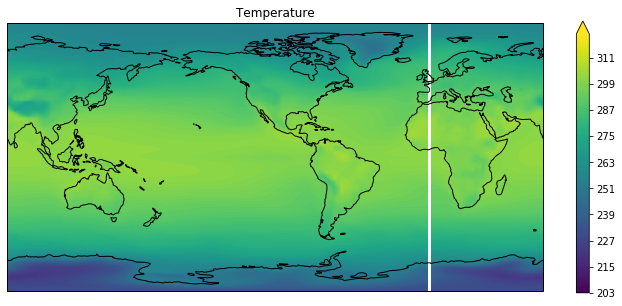

In [7]:
%matplotlib inline
fig = plt.figure(figsize=[12,5])

# Mollweide Projection 
ax = plt.axes(projection=projection)
ax.set_global()
ax.coastlines()

cf = ax.contourf(lon, lat, tas,
                       levels=np.arange(203, 323, 1),
                       extend='max',
                       transform=data_crs,
                       cbar_kwargs={'label': dset.tas.units})

plt.colorbar(cf)
plt.title("Temperature")
plt.show()

## Part ll

Text(0.0, 1.0, 'Global Yearly Mean Temperatures')

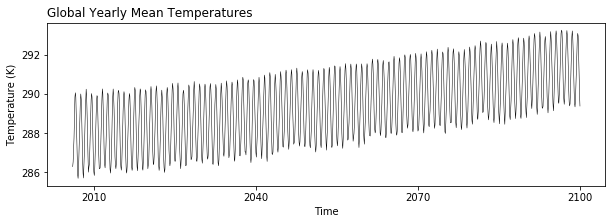

In [8]:
# Convert latitude to radians
latr = np.deg2rad(lat)

# Use the cosine of the converted latitudes as weights for the average
weights = np.cos(latr)

# Then take the weighted average of those using the weights we calculated earlier
lat_mean = weighted_mean(data_da= period.tas, dim = 'lat', weights =weights)
lat_glob_av = lat_mean.mean(dim ='lon')


plt.figure(figsize = (10,3))
plt.plot(lat_glob_av.time, lat_glob_av.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Yearly Mean Temperatures', loc='left')

## Part lll

**Calculate baseline mean**

In [9]:
year_av = lat_glob_av.groupby('time.year').mean(dim ='time')

baseline = year_av.sel(year = slice('2006-01-01','2035-12-31'))
baseline_av = baseline.mean(dim = 'year')
print(baseline_av)

<xarray.DataArray ()>
array(288.237086)
Coordinates:
    height   float64 2.0


In [10]:
anom = year_av - baseline_av
print(anom.data)

[-0.28343621 -0.40230747 -0.26605783 -0.29221911 -0.33390738 -0.16578088
 -0.09231852 -0.2060767  -0.05096819 -0.19130781 -0.20469806 -0.05772119
 -0.05845633 -0.07664291  0.05080237  0.04244756 -0.1850521  -0.06848746
  0.15713788  0.15224798 -0.04873942  0.13605334  0.1887498   0.21489027
  0.28409181  0.24880944  0.16281984  0.25553617  0.42641518  0.38073971
  0.37786704  0.55238698  0.45581779  0.45050848  0.54744182  0.59064959
  0.61427104  0.62513107  0.78803123  0.96908087  0.95628599  0.98904564
  0.94710545  0.96265114  0.8734616   0.91292379  1.07609791  1.00976402
  1.11681465  1.0336625   1.19095688  1.29720077  1.27131764  1.17293258
  1.32751748  1.5452401   1.55642949  1.47228583  1.48701074  1.59921357
  1.62250695  1.79923118  1.82703573  1.72485949  1.78256652  1.85494547
  2.04715074  1.91915376  1.90564932  2.01892924  2.07111258  1.94501537
  1.98802631  2.0958586   2.27785577  2.45971188  2.49190768  2.26222544
  2.26485367  2.31690196  2.34147547  2.48891967  2

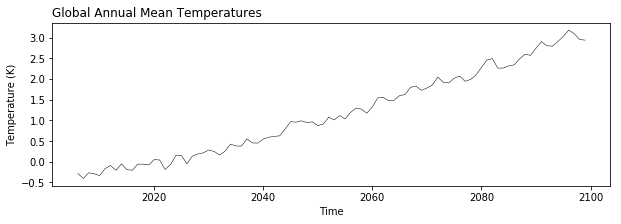

In [11]:
plt.figure(figsize = (10,3))
plt.plot(anom.year, anom.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Annual Mean Temperatures', loc='left')
fig2=plt.savefig('assign2_anom')

## Part lll

**Resample by season**

In [12]:
season = period.resample(time = "QS-DEC", label = 'right', closed = 'left').mean()
print(season.time)

<xarray.DataArray 'time' (time: 377)>
array([cftime.DatetimeNoLeap(2006, 3, 1, 0, 0, 0, 0, 0, 60),
       cftime.DatetimeNoLeap(2006, 6, 1, 0, 0, 0, 0, 1, 152),
       cftime.DatetimeNoLeap(2006, 9, 1, 0, 0, 0, 0, 2, 244), ...,
       cftime.DatetimeNoLeap(2099, 9, 1, 0, 0, 0, 0, 4, 244),
       cftime.DatetimeNoLeap(2099, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(2100, 3, 1, 0, 0, 0, 0, 3, 60)], dtype=object)
Coordinates:
  * time     (time) object 2006-03-01 00:00:00 ... 2100-03-01 00:00:00
    height   float64 2.0


In [13]:
fig = plt.figure()

for i, num in range(season.time): 
    if(i == 3):
        plt.subplot(4, 2, num)
        plt.plot()

TypeError: 'DataArray' object cannot be interpreted as an integer

<Figure size 432x288 with 0 Axes>

In [ ]:
# Check for leap year
def leap_year(y):
    if y % 400 == 0:
        return True
    if y % 100 == 0:
        return False
    if y % 4 == 0:
        return True
    else:
        return False

In [15]:
def get_dpm(time, calander = 'standard'):
    month_length = np.zeros(len(time), dtype = np.int)
    cal_days = dpm[calendar]
    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calandar = calandar):
            month_length[i] += 1
    return month_length

In [16]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(period.time.to_index(), calendar='noleap')

SyntaxError: unexpected EOF while parsing (<ipython-input-16-5a8afe60bfe6>, line 2)